In [34]:
# USAGE
# python watershed.py --image images/coins_01.png
# import the necessary packages
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
from scipy import signal
import numpy as np
import argparse
import cv2
%matplotlib inline
from matplotlib import pyplot as plt
import pims

In [35]:
#Image Loading
str1 = 'images/'
date = '25_03_19'
name = 'Cd_dots_K_Glluc'
other = '/Cd_dots_K_Glluc_10 min_postkgluc/jpg_ch01/'
extension = '*.jpg'

path = str1+date+'/'+name+other+extension

frames = pims.ImageSequence(path, as_grey=True)
total_frames = len(frames)

image= np.float64(frames[0])
for frameNum in range(1, total_frames-1):
    image = np.sum([image,np.int64(frames[frameNum])],axis=0)
    
image=image/image.max()
image = np.array(image * 255, dtype = np.uint8)

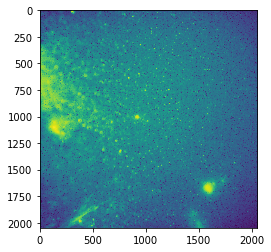

In [36]:
plt.imshow(image)
#plt.savefig('subbed.png', dpi = 1000)

94822


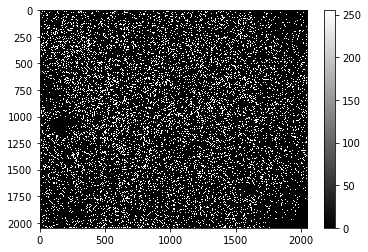

In [37]:
import cv2
stacked_img = np.stack((image,)*3, axis=-1)

gray = cv2.cvtColor(stacked_img, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5,5), 0)
maxValue = 255
adaptiveMethod = cv2.ADAPTIVE_THRESH_GAUSSIAN_C#cv2.ADAPTIVE_THRESH_MEAN_C #cv2.ADAPTIVE_THRESH_GAUSSIAN_C
thresholdType = cv2.THRESH_BINARY#cv2.THRESH_BINARY #cv2.THRESH_BINARY_INV
blockSize = 11 #odd number like 3,5,7,9,11
C = -2 # constant to be subtracted
im_thresholded = cv2.adaptiveThreshold(gray, maxValue, adaptiveMethod, thresholdType, blockSize, C) 
labelarray, particle_count = ndimage.measurements.label(im_thresholded)
print particle_count
plt.figure(1)
plt.imshow(im_thresholded,cmap='gray', aspect='auto')
plt.colorbar()

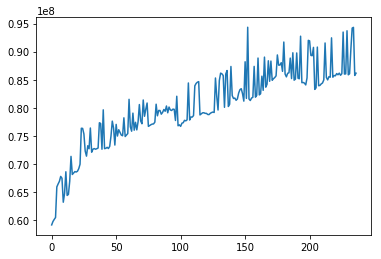

In [38]:
frame_index = np.linspace(0,total_frames-1,total_frames,dtype='int')
frame_intensity = [0] * total_frames
overall_dict = dict(zip(frame_index, frame_intensity))

for key1, value1 in enumerate(frames): #key1: frame number, value1: frame info
    overall_dict[key1] = np.sum(im_thresholded*value1)
    
final_res = str1+date+'/'+name+other+'z.png'

fig = plt.figure()
ax = plt.axes()
ax.plot(overall_dict.keys(), overall_dict.values());
#fig.savefig(final_res, bbox_inches='tight',dpi = 1000)

In [ ]:
#Image Preprocess
plt.hist(image.ravel(),256,[0,256]); plt.show()
plt.imshow(image,cmap='gray', aspect='auto')
plt.colorbar()

In [ ]:
stacked_img = np.stack((image,)*3, axis=-1)
shifted = cv2.pyrMeanShiftFiltering(stacked_img, 15, 5)
gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
plt.imshow(thresh)

# compute the exact Euclidean distance from every binary pixel to the nearest zero pixel, then find peaks in this
# distance map
D = ndimage.distance_transform_edt(thresh)
localMax = peak_local_max(D, indices=False, min_distance=10, labels=thresh,exclude_border=True)

In [ ]:
# perform a connected component analysis on the local peaks,
# using 8-connectivity, then appy the Watershed algorithm
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=thresh)
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))
kept_mask = np.zeros(gray.shape, dtype="uint8")
# loop over the unique labels returned by the Watershed
# algorithm
kept_particle = 0
for label in np.unique(labels):
    # if the label is zero, we are examining the 'background'
    # so simply ignore it
    if label == 0:
        continue
    # otherwise, allocate memory for the label region and draw
    # it on the mask
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[labels == label] = 255
    numPixels = cv2.countNonZero(mask)
 
    # if the number of pixels in the component is sufficiently
    # large, then add it to our mask of "large blobs"
    if numPixels < 500:
        if numPixels > 5:
            kept_mask = cv2.add(kept_mask, mask)
            kept_particle = kept_particle + 1
#            # detect contours in the mask and grab the largest one
#            cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
#            c = max(cnts, key=cv2.contourArea)   
#            # draw a circle enclosing the object
#            ((x, y), r) = cv2.minEnclosingCircle(c)
#            cv2.circle(image, (int(x), int(y)), int(r), (0, 255, 0), 2)
#            cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)),
#                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

# show the output image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#plt.imshow(image)
#plt.show()

plt.imshow(kept_mask)
#plt.savefig('example.png', dpi = 1000)

print(kept_particle)

In [ ]:
frame_index = np.linspace(0,total_frames-1,total_frames,dtype='int')
frame_intensity = [0] * total_frames
overall_dict = dict(zip(frame_index, frame_intensity))

for key1, value1 in enumerate(frames): #key1: frame number, value1: frame info
    overall_dict[key1] = np.sum(kept_mask*value1)

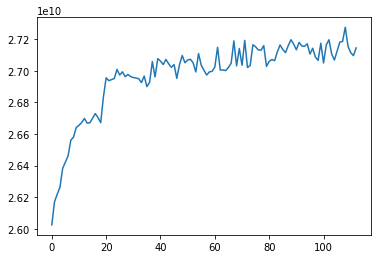

In [11]:
final_res = str1+date+'/'+name+other+'z.png'

fig = plt.figure()
ax = plt.axes()
ax.plot(overall_dict.keys(), overall_dict.values());
#fig.savefig(final_res, bbox_inches='tight',dpi = 1000)